Replicating example 3.1 in https://arxiv.org/abs/1903.04556.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import jax.numpy as np
from jax import device_get, random, vmap
from jax.config import config; config.update('jax_platform_name', 'cpu')
from jax.tree_util import tree_map, tree_multimap

import numpyro.distributions as dist
from numpyro.distributions.util import softmax
from numpyro.hmc_util import initialize_model, log_density
from numpyro.mcmc import mcmc
from numpyro.handlers import sample, scale, seed, substitute

### banana model

In [2]:
def model(data, K=10):
    x1 = sample('x1', dist.Normal(0, 0.5))
    x2 = sample('x2', dist.Normal(0, 0.5))
    with scale(K):
        return sample('obs', dist.Normal(x1 + x2 ** 2, np.sqrt(2)), obs=data)

### generate data

In [3]:
def simulate(rng, num_data=10000):
    rngs = random.split(rng, num_data)
    return vmap(lambda rng: substitute(seed(model, rng), {'x1': 0.5, 'x2': 0})(None))(rngs)

data = simulate(random.PRNGKey(0))
shards = [data[i * 1000: i * 1000 + 1000] for i in range(10)]

### get subposteriors

In [4]:
def get_subposterior(rng, shard):
    rngs = random.split(rng, 4)
    init_params, potential_fn, constrain_fn = initialize_model(rngs, model, shard)
    samples = mcmc(num_warmup=4000, num_samples=4000, init_params=init_params, num_chains=4,
                   potential_fn=potential_fn, constrain_fn=constrain_fn, print_summary=True)
    return samples

In [5]:
rngs = random.split(random.PRNGKey(1), 10)
# in the future, we can use pmap inside pmap
subposteriors = []
for i, (rng, shard) in enumerate(zip(rngs, shards)):
    print('\n==================== SUBPOSTERIOR {} ===================='.format(i))
    subposteriors.append(get_subposterior(rng, shard))


==================== SUBPOSTERIOR 0 ====================


                           mean         sd       5.5%      94.5%      n_eff       Rhat
                  x1       0.30       0.24      -0.04       0.56     984.11       1.01
                  x2       0.00       0.48      -0.77       0.72    1027.86       1.01

==================== SUBPOSTERIOR 1 ====================


                           mean         sd       5.5%      94.5%      n_eff       Rhat
                  x1       0.27       0.24      -0.08       0.52     587.45       1.01
                  x2       0.02       0.48      -0.65       0.83     856.59       1.01

==================== SUBPOSTERIOR 2 ====================


                           mean         sd       5.5%      94.5%      n_eff       Rhat
                  x1       0.28       0.24      -0.09       0.54     222.25       1.01
                  x2       0.03       0.49      -0.65       0.86     227.90       1.01

==================== SUBPOSTERIOR 3 

### plot subposteriors

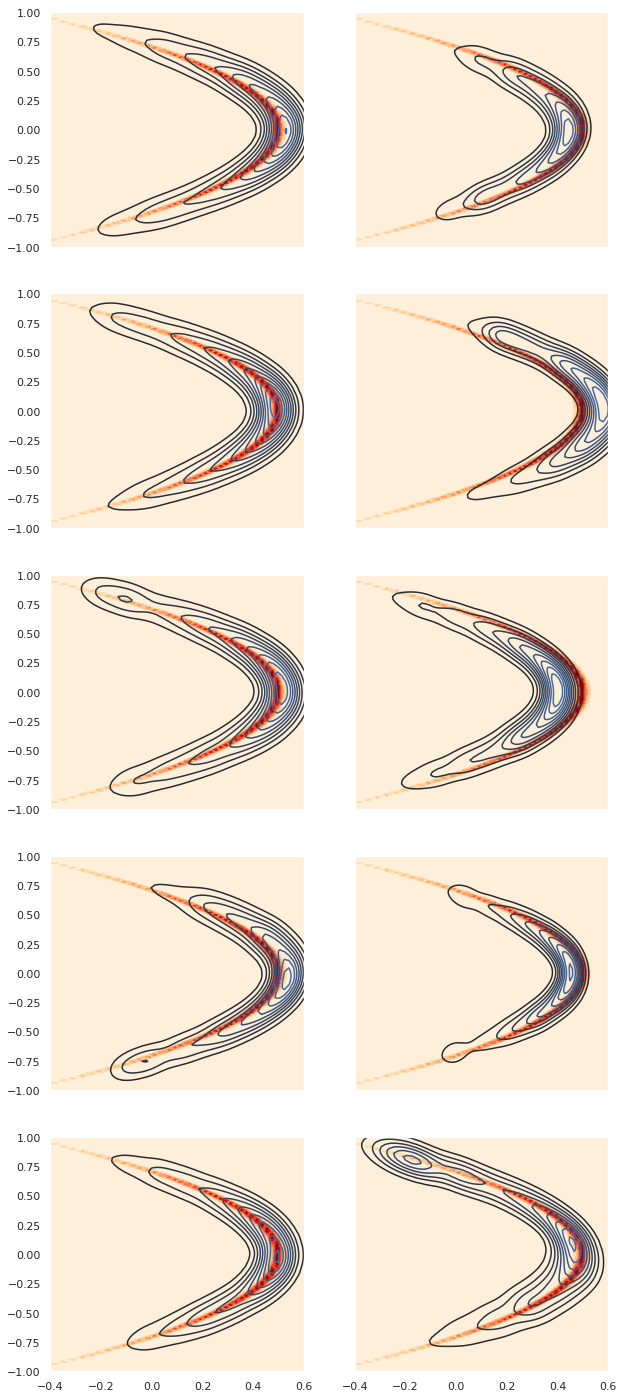

In [6]:
x1 = np.linspace(-1.0, 1.0, 100)
x2 = np.linspace(-1.0, 1.0, 100)
X1, X2 = np.meshgrid(x1, x2)
potential_energy = lambda params: log_density(model, (data,), {'K': 1}, params)[0]
logP = vmap(vmap(potential_energy))({'x1': X1, 'x2': X2})
P = softmax(logP.reshape(-1)).reshape(logP.shape).clip(a_min=0.)

_, axes = plt.subplots(5, 2, figsize=(10, 25), sharex=True, sharey=True)
for i in range(5):
    for j in range(2):
        subposterior = subposteriors[i + 5 * j]
        axes[i, j].contourf(X1, X2, P, cmap='OrRd')
        sns.kdeplot(subposterior['x1'], subposterior['x2'], ax=axes[i, j])
        axes[i, j].set_xlim([-0.4, 0.6])
        axes[i, j].set_ylim([-1.0, 1.0])

### get consensus samples

In [7]:
posterior = tree_multimap(lambda *args: np.stack(args), *subposteriors)
weights = tree_map(lambda x: np.var(x, axis=1), posterior)
consensus_samples = tree_multimap(
    lambda weights, posterior: np.dot(weights, posterior) / sum(weights),
    weights, posterior)

### plot consensus samples

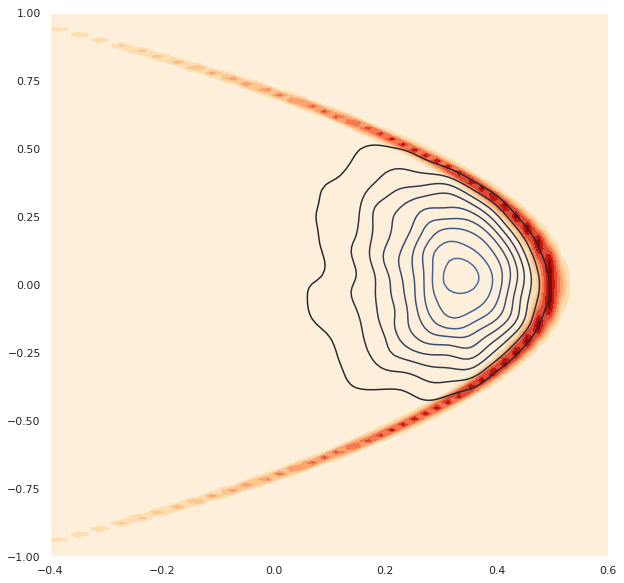

In [8]:
plt.figure(figsize=(10, 10))
plt.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(consensus_samples['x1'], consensus_samples['x2'])
plt.xlim([-0.4, 0.6])
plt.ylim([-1.0, 1.0])
plt.show()